In [1]:
### Import block

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import pandas as pd
import gdown
import zipfile
import os

In [3]:
# sub import

In [4]:
from tensorflow.python.keras.utils.version_utils import callbacks
from torchvision import datasets, transforms
from keras.callbacks import ModelCheckpoint

In [5]:
### Loading data into the workspace

In [6]:
file_id = "1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
url = f"https://drive.google.com/uc?id={file_id}"
output = "Teeth Dataset.zip"
gdown.download(url, output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=44d4f6d9-45cb-405d-9cde-d6c56c0265a5
To: C:\Users\NV_User\Code\Teeth Dataset.zip
100%|█████████████████████████████████████████████████████████████████████████████| 49.1M/49.1M [00:33<00:00, 1.46MB/s]


'Teeth Dataset.zip'

In [7]:
# unzip

In [8]:
with zipfile.ZipFile(output) as zip_ref:
    zip_ref.extractall("Teeth_Dataset")


In [9]:
# loading details

In [10]:
data_directory = "Teeth_Dataset/Teeth_Dataset"
diseases = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
img_size = (128,128)
batch_size = 32

In [11]:
# training data

In [12]:
dataset_training = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, "Training"),
    image_size=img_size,
    batch_size=batch_size,
    class_names=diseases)

Found 3087 files belonging to 7 classes.


In [13]:
# validation data

In [14]:
dataset_validation = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, "Validation"),
    image_size=img_size,
    batch_size=batch_size)

Found 1028 files belonging to 7 classes.


In [15]:
# testing data

In [19]:
dataset_testing = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, "Testing"),
    image_size=img_size,
    batch_size=batch_size)

Found 1508 files belonging to 10 classes.


In [ ]:
#data augmentation

In [51]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])
dataset_training = dataset_training.map(lambda x, y: (data_augmentation(x, training=True), y))

In [17]:
# normalization

In [52]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset_training = dataset_training.map(lambda x, y: (normalization_layer(x), y))
dataset_validation = dataset_validation.map(lambda x, y: (normalization_layer(x), y))
dataset_testing = dataset_testing.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
### Building the model

In [53]:
def classifier():
    model = tf.keras.models.Sequential([
        # input layer
        tf.keras.Input(shape=(128,128,3)),
        
        # first convolution and pooling layer
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),

        # second convolution and pooling layer
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),

        # third convolution and pooling layer
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),

        # flattening
        tf.keras.layers.Flatten(),

        # fully connected layers
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=7, activation='softmax')
    ])
    # complie
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        
    )
    #output
    return model

In [ ]:
# training the model

In [54]:
teeth_classifier = classifier()

In [ ]:
# history

In [ ]:
history = teeth_classifier.fit(dataset_training.shuffle(1000),
                           validation_data=dataset_validation,
                           epochs=50)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.1642 - loss: 1.9375 - val_accuracy: 0.1751 - val_loss: 1.9310
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.1717 - loss: 1.9345 - val_accuracy: 0.1751 - val_loss: 1.9308
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.1746 - loss: 1.9318 - val_accuracy: 0.1751 - val_loss: 1.9302
Epoch 4/50
68/97 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.1735 - loss: 1.9331

In [ ]:
# visualization function

In [30]:
def visualization(accuracy, validation_accuracy, loss, validation_loss,epochs):
    plt.figure(figsize=(10,5))
    plt.plot(epochs, accuracy, "r", label="Training Accuracy")
    plt.plot(epochs, validation_accuracy, "g", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc=0)
    # new figure
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training Loss")
    plt.plot(epochs, validation_loss, "y", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc=0)
    plt.show()

In [ ]:
#history data acquisition

In [44]:
teeth_classifier_history = history.history
accuracy = teeth_classifier_history["accuracy"]
validation_accuracy = teeth_classifier_history["val_accuracy"]
loss = teeth_classifier_history["loss"]
validation_loss = teeth_classifier_history["val_loss"]
epochs = history.epoch

In [36]:
#visualization execution

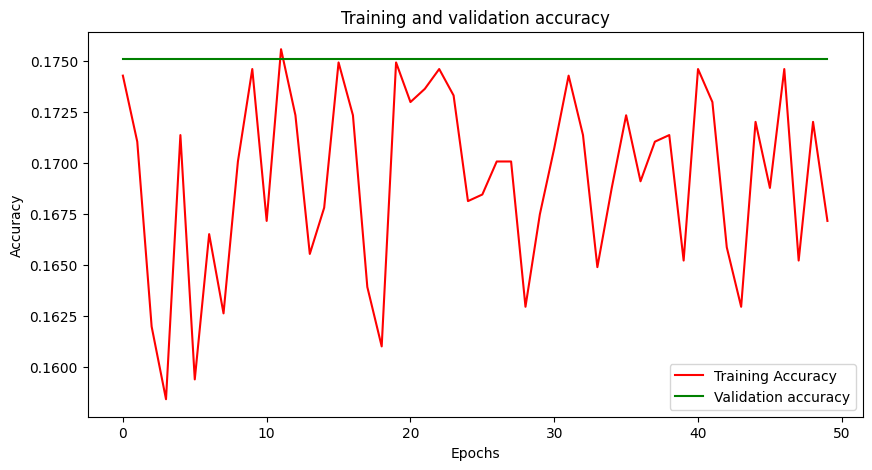

<Figure size 640x480 with 0 Axes>

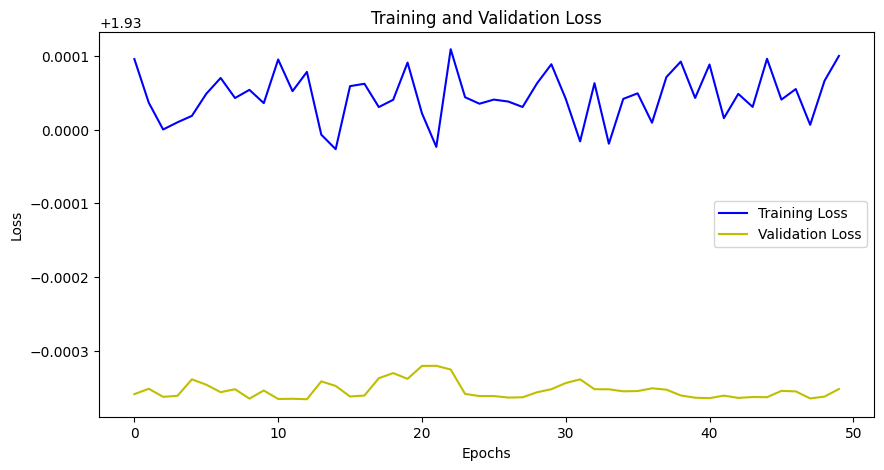

In [45]:
visualization(accuracy,validation_accuracy, loss, validation_loss, epochs)